In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mantasu/face-attributes-grouped")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mantasu/face-attributes-grouped


100%|██████████| 1.50G/1.50G [00:16<00:00, 96.4MB/s]


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

In [5]:
# 1. CONFIGURATION
BASE_DIR = '/content/face-attributes-grouped/face-attributes-grouped'  # change if needed
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 25
EPOCHS_FINE = 75

# Only train 'headwear_model' category
CATEGORY = 'headwear'
CLASSES =  ['headtop', 'helmet', 'hoodie', 'no_headwear']

In [6]:
# 2. Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(TRAIN_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)
val_gen = datagen_val.flow_from_directory(
    os.path.join(VAL_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen_val.flow_from_directory(
    os.path.join(TEST_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [7]:
# 3. Build model
def build_model(num_classes, input_shape=(224,224,3)):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

model = build_model(num_classes=len(CLASSES), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Phase 1: train head only
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
model.layers[-1].trainable = True  # only final Dense

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_phase1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=cb1
)

# Phase 2: fine-tune top layers
model.load_weights(f'best_{CATEGORY}_phase1.h5')
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_final.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=cb2
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6457 - loss: 0.8870
Epoch 1: val_loss improved from inf to 0.45709, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 593ms/step - accuracy: 0.6465 - loss: 0.8854 - val_accuracy: 0.8550 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8222 - loss: 0.4765
Epoch 2: val_loss improved from 0.45709 to 0.41776, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - accuracy: 0.8222 - loss: 0.4765 - val_accuracy: 0.8650 - val_loss: 0.4178 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8425 - loss: 0.4476
Epoch 3: val_loss did not improve from 0.41776
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.8424 - loss: 0.4476 - val_accuracy: 0.8575 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8523 - loss: 0.4242
Epoch 4: val_loss improved from 0.41776 to 0.38866, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - accuracy: 0.8523 - loss: 0.4241 - val_accuracy: 0.8775 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8504 - loss: 0.4142
Epoch 5: val_loss did not improve from 0.38866
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8504 - loss: 0.4142 - val_accuracy: 0.8725 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8585 - loss: 0.3966
Epoch 6: val_loss improved from 0.38866 to 0.36884, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.8585 - loss: 0.3967 - val_accuracy: 0.8725 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8527 - loss: 0.4026
Epoch 7: val_loss did not improve from 0.36884
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.8527 - loss: 0.4025 - val_accuracy: 0.8825 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8604 - loss: 0.3937
Epoch 8: val_loss did not improve from 0.36884
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - accuracy: 0.8604 - loss: 0.3937 - val_accuracy: 0.8725 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8548 - loss: 0.3743
Epoch 9: val_loss improved from 0.36884 to 0.36621, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.8549 - loss: 0.3744 - val_accuracy: 0.8825 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8632 - loss: 0.3618
Epoch 10: val_loss improved from 0.36621 to 0.36548, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - accuracy: 0.8632 - loss: 0.3620 - val_accuracy: 0.8900 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8605 - loss: 0.3764
Epoch 11: val_loss did not improve from 0.36548
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.8605 - loss: 0.3764 - val_accuracy: 0.8925 - val_loss: 0.3726 - learning_rate: 0.0010
Epoch 12/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8665 - loss: 0.3642
Epoch 12: val_loss did not improve from 0.36548
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.8665 - loss: 0.3644 - val_accuracy: 0.8825 - val_loss: 0.3693 - learning_rate: 0.0010
Epoch 13/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8620 - loss: 0.3783
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss did not improve from 0.36548
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 446ms/step - accuracy: 0.8620 - loss: 0.3783 -

125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - accuracy: 0.8589 - loss: 0.3815 - val_accuracy: 0.8800 - val_loss: 0.3640 - learning_rate: 5.0000e-04
Epoch 16/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8521 - loss: 0.3899
Epoch 16: val_loss did not improve from 0.36396
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - accuracy: 0.8522 - loss: 0.3898 - val_accuracy: 0.8925 - val_loss: 0.3672 - learning_rate: 5.0000e-04
Epoch 17/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8744 - loss: 0.3462
Epoch 17: val_loss improved from 0.36396 to 0.36238, saving model to best_headwear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.8744 - loss: 0.3464 - val_accuracy: 0.8875 - val_loss: 0.3624 - learning_rate: 5.0000e-04
Epoch 18/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8616 - loss: 0.3559
Epoch 18: val_loss did not improve from 0.36238
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.8616 - loss: 0.3559 - val_accuracy: 0.8900 - val_loss: 0.3669 - learning_rate: 5.0000e-04
Epoch 19/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8753 - loss: 0.3577
Epoch 19: val_loss did not improve from 0.36238
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.8752 - loss: 0.3578 - val_accuracy: 0.8950 - val_loss: 0.3635 - learning_rate: 5.0000e-04
Epoch 20/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8662 - loss: 0.3489
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_loss did not improve from 0.36238
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - accuracy: 0.8662 - lo

125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 671ms/step - accuracy: 0.7174 - loss: 0.7296 - val_accuracy: 0.8875 - val_loss: 0.3942 - learning_rate: 1.0000e-05
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8216 - loss: 0.4878
Epoch 2: val_loss improved from 0.39417 to 0.35669, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.8216 - loss: 0.4877 - val_accuracy: 0.8950 - val_loss: 0.3567 - learning_rate: 1.0000e-05
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8685 - loss: 0.3774
Epoch 3: val_loss improved from 0.35669 to 0.31901, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 581ms/step - accuracy: 0.8684 - loss: 0.3774 - val_accuracy: 0.8975 - val_loss: 0.3190 - learning_rate: 1.0000e-05
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8827 - loss: 0.3421
Epoch 4: val_loss improved from 0.31901 to 0.28844, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 586ms/step - accuracy: 0.8827 - loss: 0.3421 - val_accuracy: 0.9050 - val_loss: 0.2884 - learning_rate: 1.0000e-05
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8906 - loss: 0.3112
Epoch 5: val_loss improved from 0.28844 to 0.27203, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.8907 - loss: 0.3112 - val_accuracy: 0.9200 - val_loss: 0.2720 - learning_rate: 1.0000e-05
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9093 - loss: 0.2738
Epoch 6: val_loss improved from 0.27203 to 0.25935, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 585ms/step - accuracy: 0.9092 - loss: 0.2738 - val_accuracy: 0.9225 - val_loss: 0.2593 - learning_rate: 1.0000e-05
Epoch 7/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9190 - loss: 0.2389
Epoch 7: val_loss improved from 0.25935 to 0.25399, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.9190 - loss: 0.2389 - val_accuracy: 0.9225 - val_loss: 0.2540 - learning_rate: 1.0000e-05
Epoch 8/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9182 - loss: 0.2402
Epoch 8: val_loss improved from 0.25399 to 0.25086, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 580ms/step - accuracy: 0.9182 - loss: 0.2401 - val_accuracy: 0.9275 - val_loss: 0.2509 - learning_rate: 1.0000e-05
Epoch 9/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9291 - loss: 0.2175
Epoch 9: val_loss improved from 0.25086 to 0.24557, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9291 - loss: 0.2175 - val_accuracy: 0.9300 - val_loss: 0.2456 - learning_rate: 1.0000e-05
Epoch 10/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9265 - loss: 0.2199
Epoch 10: val_loss improved from 0.24557 to 0.23326, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 582ms/step - accuracy: 0.9265 - loss: 0.2198 - val_accuracy: 0.9400 - val_loss: 0.2333 - learning_rate: 1.0000e-05
Epoch 11/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9336 - loss: 0.1911
Epoch 11: val_loss did not improve from 0.23326
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 580ms/step - accuracy: 0.9335 - loss: 0.1912 - val_accuracy: 0.9375 - val_loss: 0.2354 - learning_rate: 1.0000e-05
Epoch 12/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9443 - loss: 0.1665
Epoch 12: val_loss improved from 0.23326 to 0.22684, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.9443 - loss: 0.1665 - val_accuracy: 0.9425 - val_loss: 0.2268 - learning_rate: 1.0000e-05
Epoch 13/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9484 - loss: 0.1618
Epoch 13: val_loss improved from 0.22684 to 0.22277, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 581ms/step - accuracy: 0.9484 - loss: 0.1619 - val_accuracy: 0.9475 - val_loss: 0.2228 - learning_rate: 1.0000e-05
Epoch 14/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9424 - loss: 0.1635
Epoch 14: val_loss improved from 0.22277 to 0.21745, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9424 - loss: 0.1635 - val_accuracy: 0.9500 - val_loss: 0.2175 - learning_rate: 1.0000e-05
Epoch 15/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9444 - loss: 0.1541
Epoch 15: val_loss improved from 0.21745 to 0.21611, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 582ms/step - accuracy: 0.9444 - loss: 0.1540 - val_accuracy: 0.9450 - val_loss: 0.2161 - learning_rate: 1.0000e-05
Epoch 16/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9459 - loss: 0.1546
Epoch 16: val_loss improved from 0.21611 to 0.20942, saving model to best_headwear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.9459 - loss: 0.1546 - val_accuracy: 0.9525 - val_loss: 0.2094 - learning_rate: 1.0000e-05
Epoch 17/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9566 - loss: 0.1349
Epoch 17: val_loss did not improve from 0.20942
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 580ms/step - accuracy: 0.9566 - loss: 0.1348 - val_accuracy: 0.9550 - val_loss: 0.2159 - learning_rate: 1.0000e-05
Epoch 18/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9514 - loss: 0.1331
Epoch 18: val_loss did not improve from 0.20942
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 576ms/step - accuracy: 0.9514 - loss: 0.1331 - val_accuracy: 0.9550 - val_loss: 0.2194 - learning_rate: 1.0000e-05
Epoch 19/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9628 - loss: 0.1072
Epoch 19: val_loss did not improve from 0.20942
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9628 - loss: 0.1073 - val_accuracy: 0.9525 - val_loss: 0.2129 - learning_rate: 1.0000e-

125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 626ms/step - accuracy: 0.9650 - loss: 0.1042 - val_accuracy: 0.9525 - val_loss: 0.2084 - learning_rate: 1.0000e-05
Epoch 21/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9700 - loss: 0.0899
Epoch 21: val_loss did not improve from 0.20839
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 576ms/step - accuracy: 0.9699 - loss: 0.0899 - val_accuracy: 0.9525 - val_loss: 0.2142 - learning_rate: 1.0000e-05
Epoch 22/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9662 - loss: 0.1097
Epoch 22: val_loss did not improve from 0.20839
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 575ms/step - accuracy: 0.9662 - loss: 0.1096 - val_accuracy: 0.9500 - val_loss: 0.2259 - learning_rate: 1.0000e-05
Epoch 23/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9711 - loss: 0.0898
Epoch 23: val_loss did not improve from 0.20839
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 582ms/step - accuracy: 0.9711 - loss: 0.0898 - val_accuracy: 0.9525 - val_loss: 0.2146 - learning_rate: 1.0000e-

In [9]:
SAVE_PATH = "/content/drive/MyDrive/headware_model"
os.makedirs(SAVE_PATH, exist_ok=True)

model.save(f"{SAVE_PATH}/headware_model.h5")
print("\nModel saved to:", f"{SAVE_PATH}/headware_model.h5")


Model saved to: /content/drive/MyDrive/headware_model/headware_model.h5


In [10]:
# ---------------------------------------
#    TEST / TRAIN / VAL ACCURACY
# ---------------------------------------

# Load best final model weights
best_model_path = f"best_{CATEGORY}_final.h5"
print("Loading:", best_model_path)
model.load_weights(best_model_path)

# Evaluate Train Accuracy
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n>>> TRAIN ACCURACY: {train_acc * 100:.2f}%")

# Evaluate Validation Accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f">>> VALIDATION ACCURACY: {val_acc * 100:.2f}%")

# Evaluate Test Accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f">>> TEST ACCURACY: {test_acc * 100:.2f}%")


Loading: best_headwear_final.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - accuracy: 0.9751 - loss: 0.0677

>>> TRAIN ACCURACY: 97.70%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9284 - loss: 0.3250
>>> VALIDATION ACCURACY: 95.25%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9205 - loss: 0.2496
>>> TEST ACCURACY: 93.50%


In [11]:
# 7. FINAL PREDICTION AFTER TRAINING
# ---------------------------
def predict_accessories(img_path, threshold=0.30):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.expand_dims(np.array(img)/255.0, axis=0)

    probs = model.predict(arr)[0]

    detected = [CLASSES[i] for i, p in enumerate(probs) if p >= threshold]

    if len(detected) == 0:
        return "Person is wearing no accessories"
    return "Person is wearing " + " and ".join(detected)

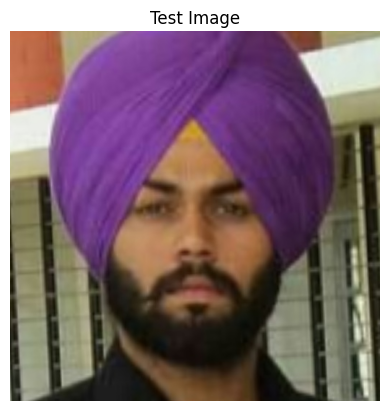


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Person is wearing headtop


In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/train/headwear/headtop/090b2583993af435ec0397b12da9726b.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


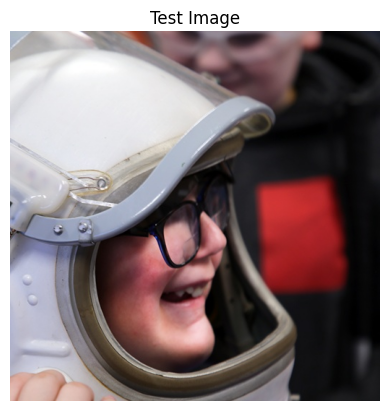


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Person is wearing helmet


In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/train/headwear/helmet/05112023-SBHelmet1.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


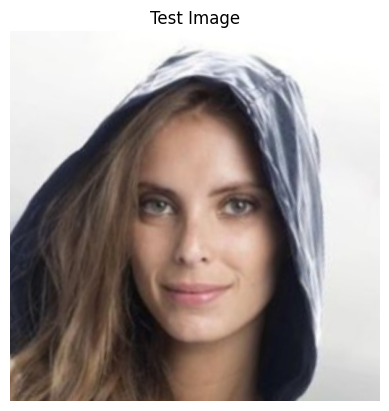


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Person is wearing hoodie


In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/train/headwear/hoodie/062952e913419ab45960ea47ce9ca4d0.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


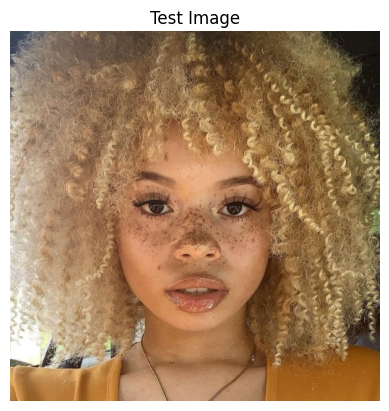


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Person is wearing no_headwear


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/train/headwear/no_headwear/04d750768cdc9b8345651d6efa6119ad.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))
